## Task description 
##### Recuirment task 


Purpose of the task is to perform an Extensive Data Analysis of text data from Health
News in Twitter Data Set, focusing on finding the topics of tweets.




# Task solution 

In first step let's open db.

In [3]:
import re
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tools


database = pd.read_pickle('./data/tweets.pkl')


[nltk_data] Downloading package stopwords to /home/xavier/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/xavier/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:

def find_expressions(database: pd.DataFrame, expression: str, sorted_by: str, percentage: bool) -> dict:
    """Returns quantity or ratio of expression in whole database"""
    data = tools.return_corpus(database, sorted_by)
    ex_amount = {key: len(re.findall(r'%s' % expression, data.loc[key].tweets)) for key in data.index}
    if percentage is True:
        ex_per = {key: value/len(database[database[sorted_by] == key]) for key, value in ex_amount.items()}
        return ex_per
    else:
        return ex_amount

Before we face with topics it is important to get some knowledge about agencies and their tweets. Twitter is often used by news agencies to reach as many people as possible by posting very short messages with URL to agency’s website embedded, if post is catchy then user will visit website. We should take a look at simple statistic. First of all let’s check how many posts includes URL links.

Lets comapre ratio of tweets with and without URL. 

Text(0.5, 1.0, 'How often tweets includes URLs')

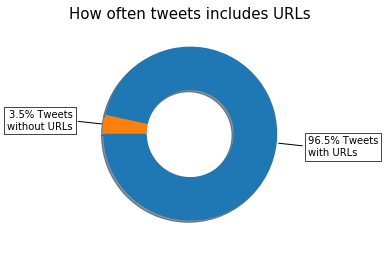

In [5]:
urls_amount = sum(find_expressions(database, 'https?', 'agency', False).values())

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
data = [urls_amount/len(database), (len(database) - urls_amount)/len(database)]
labels = [f'{data[0]*100:1.1f}% Tweets\nwith URLs', f'{data[1]*100:1.1f}% Tweets\nwithout URLs']
wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-180, shadow=True)
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title('How often tweets includes URLs', fontsize=15)

Pie chart clearly shows that almost every tweet includes URL link. Another connected question is about links distribution to a tweet, let’s take a look.

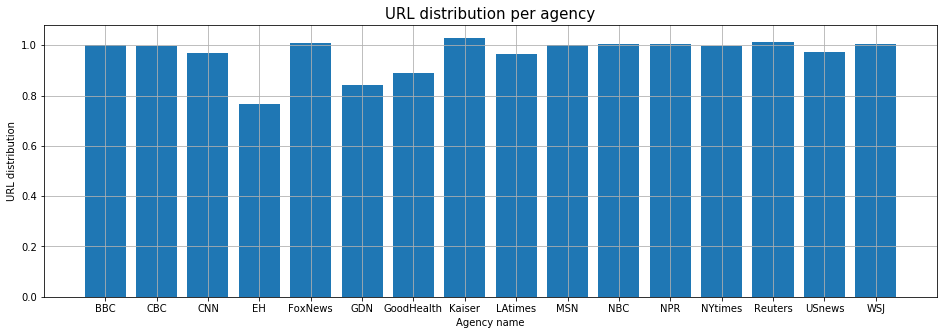

In [6]:
urls = find_expressions(database, 'https?', 'agency', True)
plt.figure(figsize=(16, 5))
plt.bar(urls.keys(), urls.values())
plt.title('URL distribution per agency', fontsize=15)
plt.xlabel('Agency name', fontsize=10)
plt.ylabel('URL distribution', fontsize=10)
plt.grid()
plt.show()


Almost every agency includes URL to post and Top Players as BBC, CBC, MSN or NewYork Times ends their tweet with link, they are using Twitter to pass information form website to word in short, catchy form and encourage users to visit agency website.  

  
Another well known marketing mechanisms from Twitter are mentions and hashtags. Both are used for increase range of recipients.

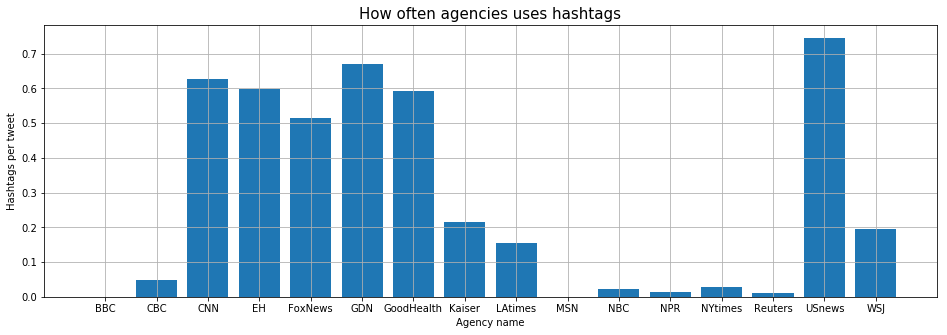

In [7]:
# hashtags distribution
tags = find_expressions(database, '#\S+', 'agency', True)
plt.figure(figsize=(16, 5))
plt.bar(tags.keys(), tags.values())
plt.title('How often agencies uses hashtags', fontsize=15)
plt.xlabel('Agency name', fontsize=10)
plt.ylabel('Hashtags per tweet', fontsize=10)
plt.grid()
plt.show()



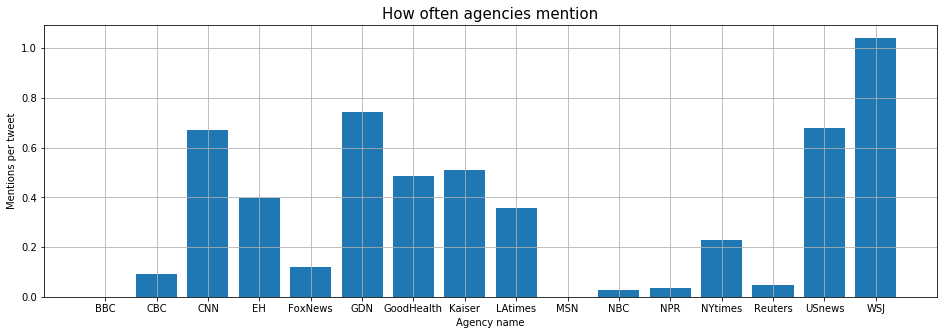

In [8]:
# mentions distribution
mentions = find_expressions(database, '@\S+', 'agency', True)
plt.figure(figsize=(16, 5))
plt.bar(mentions.keys(), mentions.values())
plt.title('How often agencies mention', fontsize=15)
plt.xlabel('Agency name', fontsize=10)
plt.ylabel('Mentions per tweet', fontsize=10)
plt.grid()
plt.show()

Basing on the two above charts we can see that mentioned before Top Player use less often marketing mechanisms. We can guess that agencies which uses hashtags more often tries to reach more users by including this keywords which users are looking for. We can also presume that agencies which mention other users are not collecting information themselves but they passing information from other agencies or independent journalists.  
  
  
There we can also mention some most often mentioned persons and agencies.

In [9]:
def popular_expressions(database: pd.DataFrame, expression: str) -> pd.Series:
    data = pd.DataFrame(database.content.apply(tools.lowercase))
    data = pd.DataFrame(data.content.apply(tools.remove_punctuation))
    data = pd.DataFrame(data.content.apply(tools.remove_stopwords))
    data = pd.DataFrame(data.content.apply(tools.remove_numberwords))
    tags = tools.flatten_list(list(map(lambda x: re.findall(r'%s' %expression, x), data.content.values)))
    freq = pd.Series(tags).value_counts()
    return freq


In [10]:
popular_mentions = popular_expressions(database, '@\S+')
print('POPULAR MENTIONS')
print(popular_mentions.head(10))

POPULAR MENTIONS
@goodhealth        897
@cynthiasass       834
@stefaniei         725
@gdnhealthcare     419
@wsj               313
@pharmalot         240
@cnnhealth         226
@everydayhealth    214
@cslnyt            178
@lauralandrowsj    176
dtype: int64


Leaving simple statistics, we can focus on content. I decided to take a look on tweets topics year by year.  
  
  
Lets preapare db to action.

In [11]:
df = pd.DataFrame(database.content.apply(tools.hard_clean))
df = pd.DataFrame(df.content.apply(tools.lemmatize))
df = pd.DataFrame(df.content.apply(tools.leave_nouns_adj))
df = pd.DataFrame(df.content.apply(tools.remove_stopwords))
df['year'] = database.year
df['agency'] = database.agency
df['month'] = database.month

Then lets create document-term matrix. It is a mathematical matrix that describes the frequency of terms that occur in a collection of documents. 

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from CONFIG import STOP 

corpus_year_data = tools.return_corpus(df, 'year')
cv = CountVectorizer(stop_words=STOP)
data_cv = cv.fit_transform(corpus_year_data.tweets)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = corpus_year_data.index



In topic modeling first of all we should focus on constructing wordclouds for each year which allows to pick trending topics.

In [13]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white', max_font_size=150, colormap='Dark2')

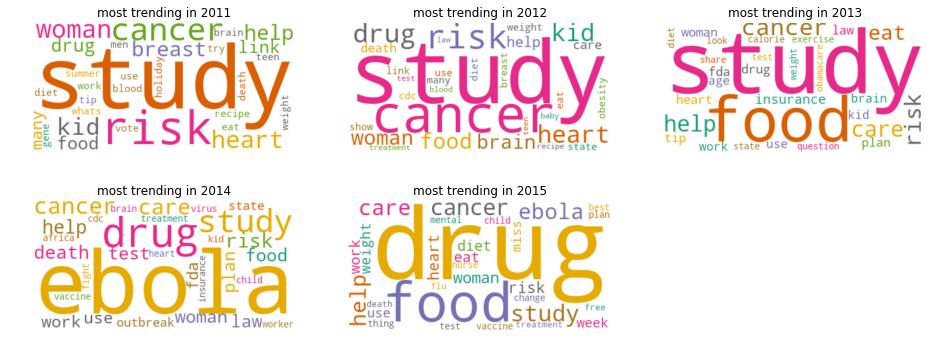

In [18]:
n_topics = 30   # number of interesting topics 

# wordclouds for every year 
trending_topics = {year: data_dtm.loc[year].nlargest(n_topics) for year in data_dtm.index}

plt.rcParams['figure.figsize'] = [16, 6]

# Create subplots for each comedian
for index, year in enumerate(trending_topics.keys()):
    wordcloud.generate_from_frequencies(trending_topics[year])
    plt.subplot(2, 3, index+1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f'most trending in {year}')
    
plt.show()


Then I compare it to trending tweets in all data.

Text(0.5, 1.0, 'Most trending tweets')

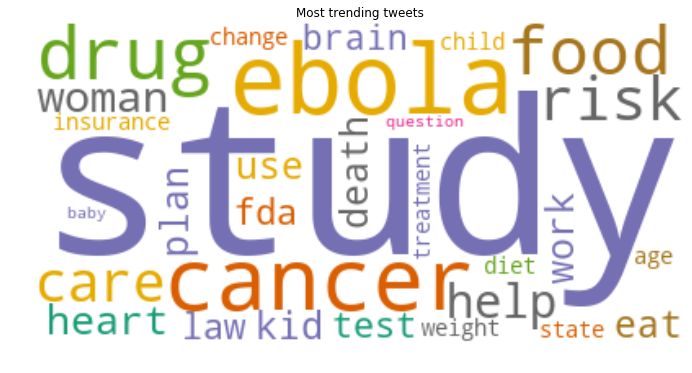

In [22]:
dtm_sum = data_dtm.sum()    # sum all words in dtm  
global_trending_topics = pd.DataFrame(dtm_sum.nlargest(n_topics)).to_dict()[0]
wordcloud = WordCloud(background_color='white', max_font_size=150, colormap='Dark2') \
    .generate_from_frequencies(global_trending_topics)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(f"Most trending tweets")

There are some most repeating topics in every year and “ebola” topic comes out nowhere. Basing on this wordclouds it’s is possible to pick some trends in health tweets.  

Obviously before creating this models it is necessary to preprocess data. I decided to remove from tweets punctuation, hashtags, mentions, url, english “stopwords” like 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under' and some other topic related words like ‘health’, ‘doctor’. I also used lemmatization method to group together the inflected forms of a word so they can be analyzed as a single item.  

In my opinion it is always important to compare collected data in this way to mathematical models, therefore I used two LDA models to topics modeling from whole data and compare them with wordcloud.

In [ ]:

tokenized_data = df.content.apply(tools.word_tokenize)


In [ ]:
import gensim

# create bag of words model
dictionary = gensim.corpora.Dictionary(tokenized_data)
bow_corpus = [dictionary.doc2bow(doc) for doc in tokenized_data]
lda_model_bow = gensim.models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=10)
lda_model_bow.save('./models/lda_bow.model')

for idx, topic in lda_model_bow.print_topics(-1):
    print('Topic: {} Words: {}'.format(idx, topic))


In [ ]:
# create term frequency inverse document frequency lda model
tfidf = gensim.models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=5, id2word=dictionary, passes=10)
lda_model_tfidf.save('./models/lda_tfidf.model')

for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))


LDA is kind of art of interpretation. After topics comparison I decided to focus on that, how topics popularity has changing in time.  

I focused on 5 topics: 'ebola', 'cancer', 'insurance', 'food', 'drug' and plot changing ratio for each topic to all tweets in piece of time.


In [ ]:
topics_list = ['ebola', 'cancer', 'insurance', 'food', 'drug']

topics = {key: [] for key in topics_list}

df = pd.DataFrame(database.content.apply(tools.lowercase))
df = pd.DataFrame(df.content.apply(tools.lemmatize))
df['year'] = database.year
df['month'] = database.month

for topic in topics.keys():
    for year in sorted(database.year.unique()):
        for month in sorted(database.month.unique()):
            df_tmp = pd.DataFrame(df[(df.year == year) & (df.month == month)])
            n_tweets = len(df_tmp)
            n_tweets_with_key = df_tmp.content.str.contains(topic).sum()
            if n_tweets == 0:
                topics[topic].append(0)
            else:
                topics[topic].append((n_tweets_with_key / n_tweets) * 100)

xticks = []
for year in sorted(database.year.unique()):
    for month in sorted(database.month.unique()):
            if month == '01':
                xticks.append(f'{month}.{year}')
            else:
                xticks.append(f'{month}')

plt.figure()
plt.yticks(range(0, 91, 10), [str(x) + "%" for x in range(0, 91, 10)], fontsize=8)
plt.xticks(range(0, 60, 1), xticks, fontsize=8, rotation=70)
plt.ylim(-1, 60)
for key, value in topics.items():
    plt.plot(topics[key], label=key)
plt.grid()
plt.xlabel('Months from 2011 to 2015')
plt.ylabel('Tweets which contains keyword [%]')
plt.title('Ratio of tweets with keyword to all Tweets', fontsize=15)
plt.legend()

Lets see that topics like ‘cancer’ or ‘food’ are almost almost always have the same popularity. Peak for ‘ebola’ is connected with epidemic at the turn of 2014 and 2015. There is also little peak for insurance keyword before 2014 and its may comes from Obamacare project which starts in 2014.

Then we can take a look on most popular hashtags and compare it with received topics. It may be figure out that a lot of tags comes from fit lifestyle but there are some tags that we can connect with topics from wordclouds and TFIDF analysis like ebola, obamacare (which could be connected with insurance)

In [1]:
popular_tags = popular_expressions(database, '#\S+')
print('POPULAR TAGS')
print(popular_tags.head(10))

NameError: name 'popular_expressions' is not defined

At the end lets take a look at sentiment analysis which refers to the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information. Sentiment analysis focus on two parameters – polarity and subjectivity. The polarity score is a number within the range [-1.0, 1.0] where -1.0 is very negative and 1.0 is very positive. The subjectivity is a number within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [2]:
corpus_df = tools.return_corpus(database, 'agency')
corpus_df = pd.DataFrame(corpus_df.tweets.apply(tools.remove_mentions))
corpus_df = pd.DataFrame(corpus_df.tweets.apply(tools.remove_tags))
corpus_df = pd.DataFrame(corpus_df.tweets.apply(tools.remove_url))
corpus_df['polarity'] = corpus_df['tweets'].apply(tools.polarity)
corpus_df['subjectivity'] = corpus_df['tweets'].apply(tools.subjectivity)

plt.figure()
for index, agency in enumerate(corpus_df.index):
    x = corpus_df.polarity.loc[agency]
    y = corpus_df.subjectivity.loc[agency]
    plt.scatter(x, y, color='C0')
    if agency == 'NYtimes':
        plt.text(x + .001, y - .004, corpus_df.index[index], fontsize=12)
    else:
        plt.text(x - .001, y + .002, corpus_df.index[index], fontsize=12)

plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)
plt.grid()
plt.show()

Basing on this scatter plot it is possible to point which agencies delivers facts eg. BBC, Reuters etc.